In [325]:
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd
import json
import cv2
import numpy as np
import seaborn as sns
import random

### Edits for MobiCom
"Powersave" policy:  set the sensor voltage to the lowest possible setting to save power.
"Performance" policy:  set the sensor voltage to the highest possible setting, providing maximum performance but potentially consuming more power and generating more heat.
"Ondemand" policy: set the sensor voltage to the lowest possible setting when the scene is idle and scale the voltage up as scene complexity increases.
"Lightutil" policy: Use ambient light sensor's reading to determine the optimal voltage setting for the current workload. It takes into account the ambient lighting and scene dynamics to determine the best voltage to use at any given time.
"Userspace" policy: Allow the developer or vision app to set the voltage directly. This can be useful for applications that have specific voltage requirements. Demonstrate intermediate voltage usability in this policy

In [326]:
legend_methods = ["Sq-Perf","Sq-Rand","Sq-Light","Sq-OD","Sq-Pwr","RR"] #original ["Nominal","Sq-Rand","Sq-AVS","Sq-DVS","RR"]

In [327]:
# This is for producing type-1 fonts
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
#TODO: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
plt.rcParams['font.family'] = 'sans-serif'
# tick_font_size_base = 15
# label_font_size_base = 18
# marker_size_base = 8
# legend_size_base = 12

high_level_scaling = 0.57

tick_font_size_base = 15*high_level_scaling
label_font_size_base = 18*high_level_scaling
marker_size_base = 9*high_level_scaling
legend_size_base = 12*high_level_scaling

#half-column figure font size = 2* full column figure font size
#TODO: Clean up this logic later.

full_col_scaling = .8
half_col_scaling = 0.50
one_third_col_scaling = 0.4

line_width = '1'


## Figure 2

In [328]:
#plot settings
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/full_col_scaling
label_font_size = label_font_size_base*high_level_scaling/full_col_scaling
marker_size = marker_size_base*high_level_scaling/full_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/full_col_scaling

### Code to generate data

In [329]:
S_U = 10
S_R = 10/5
V_REF = 3.3
BIT_ADC = 10
3403080
voltages = [2.8,2.7,2.6,2.5,2.4,2.3,2.2,2.1,2.0,1.9,1.8,1.7,1.6,1.5,1.4]
resolutions = ["mode-1","mode-2","mode-3","mode-4","mode-5","mode-6","mode-7"]
voltages.reverse()
data_frames = [] 
data_frames_res = [] 

def calc_derived_value(data_frame):
    delta_voltage_analog = np.abs(data_frame[" value ch1"] - data_frame[" value ch0"])
    current_analog = delta_voltage_analog / S_U
    power_analog = current_analog * data_frame[" value ch2"]
    
    delta_digital_voltage = np.abs(data_frame[" value ch4"] - data_frame[" value ch3"])
    current_digital = delta_digital_voltage / S_R
    power_digital = current_digital * data_frame[" value ch2"] 
    
    delta_control_voltage = np.abs(data_frame[" value ch5"] - data_frame[" value ch6"])
    power_control = (delta_control_voltage/ S_R) * V_REF
    
    data_frame["power_analog"] = power_analog
    data_frame["power_digital"] = power_digital
    data_frame["power_total"] = power_analog + power_digital
    data_frame["power_control"] = power_control 
    
    return(data_frame)

for volt in voltages: 
    df = pd.read_csv( f"./data/{volt}.csv",skiprows=1)
    keys_values = list(filter(lambda x : "value" in x, df.keys()))
    keys_samples = list(filter(lambda x : "sample" in x, df.keys()))
    df[keys_values] = (df[keys_values] / (2**BIT_ADC))*V_REF
    df = calc_derived_value(df)
    data_frames.append(df)


#resolutions 
for res in resolutions: 
    df = pd.read_csv( f"./data/{res}.csv",skiprows=1)
    keys_values = list(filter(lambda x : "value" in x, df.keys()))
    keys_samples = list(filter(lambda x : "sample" in x, df.keys()))
    df[keys_values] = (df[keys_values] / (2**BIT_ADC))*V_REF
    df = calc_derived_value(df)
    data_frames_res.append(df)
    
    
average_power = []
std_power = []
average_analog = []
average_digital = [] 
for df in data_frames: 
    average_power.append(df["power_total"].mean())
    std_power.append((df["power_total"]*1000).std())
    average_analog.append(df["power_analog"].mean())
    average_digital.append(df["power_digital"].mean())

average_power = np.array(average_power)
average_analog = np.array(average_analog)
average_digital = np.array(average_digital)
std_power = np.array(std_power)

average_power_res = []
std_power_res = []
average_analog_res = []
average_digital_res = [] 
for df in data_frames_res: 
    average_power_res.append(df["power_total"].mean())
    std_power_res.append((df["power_total"]*1000).std())
    average_analog_res.append(df["power_analog"].mean())
    average_digital_res.append(df["power_digital"].mean())

average_power_res = np.array(average_power_res)
average_analog_res = np.array(average_analog_res)
average_digital_res = np.array(average_digital_res)
std_power_res = np.array(std_power_res)
    

### Figure Code

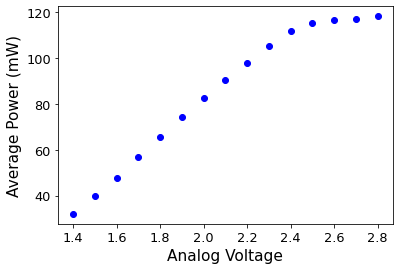

In [330]:
#plt.title("Total Power vs Analog Voltage",fontsize = label_font_size)
plt.xlabel("Analog Voltage",fontsize = label_font_size)
plt.ylabel("Average Power (mW)",fontsize = label_font_size)
plt.scatter(voltages,average_power*1000, label='Total Power',color="blue")
#plt.plot(voltages,average_digital*1000, label='Digital Power')
#plt.plot(voltages,average_analog*1000, label='Analog Power')
#plt.legend(fontsize=legend_size)
plt.axis('tight')
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig("./figs/AveragePowerVsAnalogVoltage.pdf",format='pdf', dpi=1000, bbox_inches="tight")
#plt.figsave("test.png")

In [331]:
average_power

array([0.03197184, 0.03958384, 0.04777292, 0.05666278, 0.06552448,
       0.07428166, 0.08251143, 0.09033756, 0.09779145, 0.10519745,
       0.11202695, 0.11548773, 0.11650807, 0.11714759, 0.11827307])

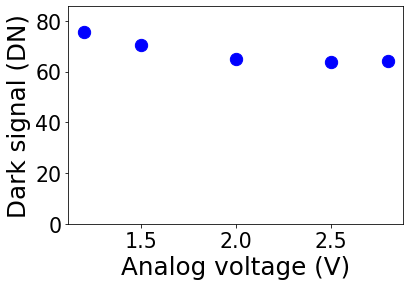

In [332]:
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/half_col_scaling
label_font_size = label_font_size_base*high_level_scaling/half_col_scaling
marker_size = marker_size_base*high_level_scaling/half_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/half_col_scaling

voltage = [1.2, 1.5, 2, 2.5, 2.8]
signal = [75.7467, 70.6017, 64.8243, 63.9944, 64.0212]

plt.figure()
plt.plot(voltage, signal, linestyle = 'None', marker = 'o', color="blue", markersize = marker_size)
plt.axis('tight')
# plt.locator_params(axis="x", nbins=10)
# plt.xlim(1, 3)
# plt.ylim(0, 75)
plt.ylim(0, max(signal)+10)
plt.xlabel('Analog voltage (V)', fontsize = label_font_size)
plt.ylabel('Dark signal (DN)', fontsize = label_font_size)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig("./DarkSignal.pdf", format='pdf', dpi=1000, bbox_inches="tight")

#plt.close()

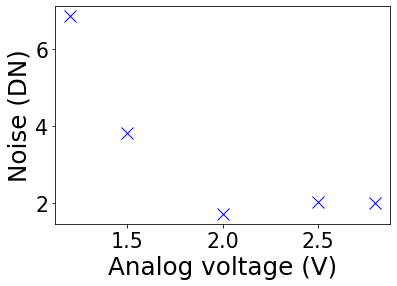

In [333]:
voltage = [1.2, 1.5, 2, 2.5, 2.8]
noise = [6.8569, 3.819, 1.7277, 2.036, 2.0035]

plt.figure()
plt.plot(voltage, noise, linestyle = 'None', marker = 'x', color="blue", markersize = marker_size)
plt.axis('tight')
# plt.locator_params(axis="x", nbins=10)
#plt.xlim(0, max(voltage)+1)
#plt.ylim(0, max(noise)+1)
plt.xlabel('Analog voltage (V)', fontsize = label_font_size)
plt.ylabel('Noise (DN)', fontsize = label_font_size)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig("./figs/TemporalNoise.pdf",format='pdf', dpi=1000, bbox_inches="tight")


## Figure 4

/media/mason/d307713c-cdbe-4462-ad7c-1c8928f3cabb/dvfs_camera/squint_impl/squintVM/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/media/mason/d307713c-cdbe-4462-ad7c-1c8928f3cabb/dvfs_camera/squint_impl/squintVM/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


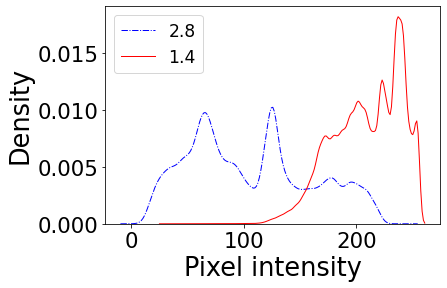

In [334]:
tick_font_size = tick_font_size_base/one_third_col_scaling
label_font_size = label_font_size_base/one_third_col_scaling
marker_size = marker_size_base/one_third_col_scaling
legend_size = legend_size_base/one_third_col_scaling

#input1 = png.read_png_int("input_cropped.png")
#input2 = png.read_png_int("output_cropped.png")
#input1 = cv2.imread('data_c/fig_4/e_2.8_0000.jpg')
#input2 = cv2.imread('data_c/fig_4/e_1.4_0000.jpg')
input1 = cv2.imread('data_c/fig_outdoor/outdoor_2p8.jpg')
input2 = cv2.imread('data_c/fig_outdoor/outdoor_1p4.jpg')
input1 = cv2.cvtColor(input1, cv2.COLOR_BGR2GRAY)
input2 = cv2.cvtColor(input2, cv2.COLOR_BGR2GRAY)

# Assign colors for each airline and the names
colors = ['blue', 'red']
names = ['2.8', '1.4']




plt.figure()         
sns.distplot(input1.ravel(),hist=False, kde=True, kde_kws={"lw":1,"label":names[0],'color':colors[0],"linestyle":"-."} )
ax = sns.distplot(input2.ravel(), hist=False, kde=True, kde_kws={'linewidth':1,"label":names[1],'color':colors[1]})

plt.legend(loc = 0, prop={'size': legend_size})
plt.xlabel('Pixel intensity',  fontsize = label_font_size)
plt.ylabel('Density',  fontsize = label_font_size)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig("./figs/PixelDesnsityHistogram.pdf", format='pdf', dpi=1000, bbox_inches="tight")


high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/one_third_col_scaling
label_font_size = label_font_size_base*high_level_scaling/one_third_col_scaling
marker_size = marker_size_base*high_level_scaling/one_third_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/one_third_col_scaling
 

image_gt = cv2.imread('data_c/fig_4/e_2.8_0005.jpg')
image_e = cv2.imread('data_c/fig_4/e_1.4_0005.jpg')
#plt.axis("off")
#plt.imshow(cv2.cvtColor(image_gt, cv2.COLOR_BGR2RGB))
 
blue_histogram = cv2.calcHist([image_gt], [0], None, [256], [0, 256])
red_histogram = cv2.calcHist([image_gt], [1], None, [256], [0, 256])
green_histogram = cv2.calcHist([image_gt], [2], None, [256], [0, 256]) 

blue_histogram_e = cv2.calcHist([image_e], [0], None, [256], [0, 256])
red_histogram_e = cv2.calcHist([image_e], [1], None, [256], [0, 256])
green_histogram_e = cv2.calcHist([image_e], [2], None, [256], [0, 256])

#plt.title("Line Plots of All Colors")
plt.xlabel("RGB Value",fontsize=label_font_size)
plt.ylabel("Intensity",fontsize=label_font_size)
plt.plot((blue_histogram +green_histogram+red_histogram)/3 ,color="darkblue",markersize=marker_size)
#plt.plot(green_histogram,color="green",markersize=marker_size)
#plt.plot(red_histogram,color="red",markersize=marker_size)
plt.xlabel("RGB Value",fontsize=label_font_size)
plt.ylabel("Intensity",fontsize=label_font_size)


plt.plot((blue_histogram_e+green_histogram_e+red_histogram_e)/3,'--',color="darkblue",markersize=marker_size)
#plt.plot(green_histogram_e,'--',color="green",markersize=marker_size)
#plt.plot(red_histogram_e,'--',color="red",markersize=marker_size)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.xlim(0, 257)
plt.ylim(0, 20000)
#plt.yaxis('off')
plt.yticks(fontsize=0.01,color='w')
#plt.tight_layout()
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.ylim(0, 20000)
#plt.yaxis('off')
plt.yticks(fontsize=0.01,color='w')
plt.xlim(0, 257)
#plt.tight_layout()
plt.savefig("./figs/4a.png", dpi=1000, bbox_inches="tight")

#plt.title("Line Plots of All Colors")
plt.xlabel("RGB Value",fontsize=label_font_size)
plt.ylabel("Intensity",fontsize=label_font_size)
plt.plot(blue_histogram_e,color="darkblue",markersize=marker_size)
plt.plot(green_histogram_e,color="green",markersize=marker_size)
plt.plot(red_histogram_e,color="red",markersize=marker_size)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.xlim(0, 257)
plt.ylim(0, 20000)
#plt.yaxis('off')
plt.yticks(fontsize=0.01,color='w')
#plt.tight_layout()
plt.savefig("./figs/4b.png", dpi=1000, bbox_inches="tight")

## Figure 5

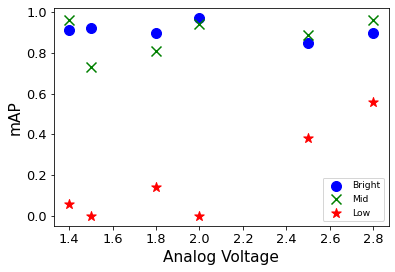

In [335]:
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/full_col_scaling
label_font_size = label_font_size_base*high_level_scaling/full_col_scaling
marker_size = marker_size_base*high_level_scaling/full_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/full_col_scaling

voltages = [2.8,2.5,2.0,1.8,1.5,1.4]
map_bright = [0.9,0.85,0.97,.8988,0.92,0.91]

map_mid = [0.96,0.89,0.94,.8078,0.73,0.96]

map_low = [0.56,0.383,0,.14,0,0.06]

#plt.title("Total Power vs Analog Voltage",fontsize = label_font_size)
plt.xlabel("Analog Voltage",fontsize = label_font_size)
plt.ylabel("mAP",fontsize = label_font_size)
size_conc = 100
plt.scatter(voltages,map_bright, label='Bright',marker = 'o',color="blue",s=size_conc)
plt.scatter(voltages,map_mid,label='Mid',marker = 'x',color="green",s=size_conc)
plt.scatter(voltages,map_low, label='Low',marker = '*',color="red",s=size_conc)
plt.legend(fontsize=legend_size)
plt.axis('tight')
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig("./figs/mAPvsAnalogVoltage.pdf",format='pdf', dpi=1000, bbox_inches="tight")
#plt.figsave("test.png")

## Fig 8

In [336]:
S_U = 10
S_R = 10/5
V_REF = 3.3
BIT_ADC = 10
T = 60 * 6
FS = 9400 #Hz
N = FS * T
#CHANGE -> AVS 
#LIGHT -> DVS
test_sections = [("high",0,60*2), ("mid", 60*2,60*4), ("low",60*4,60*6)]
data_paths = ["random-indoor","random-indoor-cafe","light-indoor","light-indoor-cafe","change-indoor","change-indoor-cafe"]
voltages = [2.8,2.7,2.6,2.5,2.4,2.3,2.2,2.1,2.0,1.9,1.8,1.7,1.6,1.5,1.4]
names = ["baseline","random", "random-cafe","light","light-cafe","change","change-cafe","480p"]
names_b = ["random", "random-cafe","light","light-cafe","change","change-cafe"]
baseline_power = 118.272012 / 1000
baseline_std = 45.454833
#adjusted to 90% duty cycle simulated 
res_480_power = 89.18290974941237 
res_480_power = res_480_power*.9 + 118.272012*.1 
res_480_std = 85.90667830669737 #simulated
#voltages.reverse()
data_frames = [] 
data_frames_split = []
times = []

def calc_derived_value(data_frame):
    delta_voltage_analog = np.abs(data_frame[" value ch1"] - data_frame[" value ch0"])
    current_analog = delta_voltage_analog / S_U
    power_analog = current_analog * data_frame[" value ch2"]
    
    delta_digital_voltage = np.abs(data_frame[" value ch4"] - data_frame[" value ch3"])
    current_digital = delta_digital_voltage / S_R
    power_digital = current_digital * data_frame[" value ch2"] 
    
    delta_control_voltage = np.abs(data_frame[" value ch5"] - data_frame[" value ch6"])
    power_control = (delta_control_voltage/ S_R) * V_REF
    
    data_frame["power_analog"] = power_analog
    data_frame["power_digital"] = power_digital
    data_frame["power_total"] = power_analog + power_digital
    data_frame["power_control"] = power_control 
    
    return(data_frame)

for path in data_paths: 
    df = pd.read_csv( f"./data_c/fig_8/{path}.csv",skiprows=1)
    keys_values = list(filter(lambda x : "value" in x, df.keys()))
    keys_samples = list(filter(lambda x : "sample" in x, df.keys()))
    df[keys_values] = (df[keys_values] / (2**BIT_ADC))*V_REF
    df = calc_derived_value(df)
    entry = {}
    for n,s,f in test_sections:
        start = df[df.isin([int(s*FS)]).any(axis=1)].index.values[0]
        finish = df[df.isin([int(f*FS)]).any(axis=1)].index.values[0]
        #print(n,start,finish)
        entry[n] = df[start:finish]
    data_frames_split.append(entry)
    
    row_max = df[df.isin([int(N)]).any(axis=1)].index.values[0]
    df = df[:row_max]
    data_frames.append(df)
    f = open(f"./data_c/fig_8/{path}.json",)
    times.append(json.load(f))
    f.close()
    

    
average_power = []
energy = []
std_power = []
average_analog = []
average_digital = [] 
for df in data_frames: 
    std_power.append((df["power_total"]*1000).std())
    average_power.append(df["power_total"].mean())
    average_analog.append(df["power_analog"].mean())
    average_digital.append(df["power_digital"].mean())
    energy.append((np.array(df["power_total"]) * 1/FS).sum())
    
average_power_split = {"high":[],
                       "high-std":[],
                       "mid" :[],
                       "mid-std" :[],
                       "low" :[],
                       "low-std" :[],} 
for df in data_frames_split:
    average_power_split["high"].append(df["high"]["power_total"].mean())
    average_power_split["mid"].append(df["mid"]["power_total"].mean())
    average_power_split["low"].append(df["low"]["power_total"].mean())
    average_power_split["high-std"].append((df["high"]["power_total"]*1000).std())
    average_power_split["mid-std"].append((df["mid"]["power_total"]*1000).std())
    average_power_split["low-std"].append((df["low"]["power_total"]*1000).std())

average_power_split["high"] = np.array([baseline_power] + average_power_split["high"]+ [res_480_power/1000])
average_power_split["mid"] = np.array([baseline_power] + average_power_split["mid"]+ [res_480_power/1000])
average_power_split["low"] = np.array([baseline_power] + average_power_split["low"]+ [res_480_power/1000])
average_power_split["high-std"] = np.array([baseline_std] + average_power_split["high-std"]+ [res_480_std])
average_power_split["mid-std"] = np.array([baseline_std] + average_power_split["mid-std"]+ [res_480_std])
average_power_split["low-std"] = np.array([baseline_std] + average_power_split["low-std"]+ [res_480_std])

average_power = np.array([baseline_power] + average_power + [res_480_power/1000])
# [BASELINE, RANDOM-INDOOR, RANDOM-CAFE, LIGHT INDOOR, LIGHT CAFE, CHANGE INDOOR, CHANGE CAFE, RR] 
std_power = np.array([baseline_std] +std_power+ [res_480_std])
average_analog = np.array(average_analog)
average_digital = np.array(average_digital)

    


In [337]:
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/full_col_scaling
label_font_size = label_font_size_base*high_level_scaling/full_col_scaling
marker_size = marker_size_base*high_level_scaling/full_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/full_col_scaling

slice_s = 1100
slice_m = 1700

plt.subplot(3,1,1)
plt.title("Random",fontsize = label_font_size)
plt.plot(times[0]["series"][slice_s:slice_m])
 
plt.subplot(3,1,2)
plt.title("AVS",fontsize = label_font_size)
plt.ylabel("Voltage",fontsize = label_font_size)
plt.plot(times[2]["series"][slice_s:slice_m])
 
plt.subplot(3,1,3)
plt.title("DVS",fontsize = label_font_size)
#simulated for figure
dvs = [] 
for i in range(0,600): 
    if(i<300): 
        if(i%20<8):
            dvs.append(2.8)
        else: 
            dvs.append(1.4)
    else:
        if(i%100<8):
            dvs.append(2.8)
        else: 
            dvs.append(1.4)

plt.xlabel("Frame Number",fontsize = label_font_size)
plt.plot(dvs)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.tight_layout()
plt.show()
#plt.savefig("./figs/8.pdf",format='pdf', dpi=1000, bbox_inches="tight")

## Fig 9

random


light


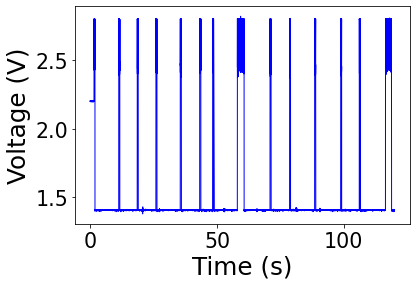

change


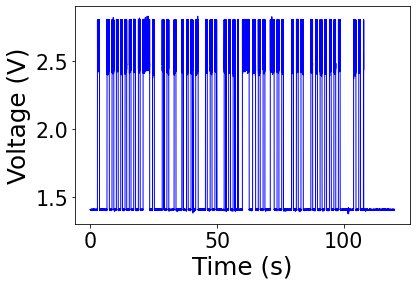

In [338]:
#Trail Entrance 
#Voltage vs Time Charts
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/half_col_scaling
label_font_size = label_font_size_base*high_level_scaling/half_col_scaling
marker_size = marker_size_base*high_level_scaling/half_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/half_col_scaling

i=0
j = 0 
r = "high"
indexes = [0,2,4]
letters = ['a','b','c']
for idx,i in enumerate(indexes):
    print(names_b[i])
    #plt.title(f"Voltage vs Time {names_b[i]} Policy")
    plt.xlabel("Time (s)",fontsize = label_font_size)
    plt.ylabel("Voltage (V)",fontsize = label_font_size)
    plt.tick_params(axis = 'both', labelsize = tick_font_size)
    plt.plot(np.linspace(0,60*2,len((data_frames_split[i][r][" value ch2"]))),(data_frames_split[i][r][" value ch2"]),color="blue",linewidth=1)
    plt.savefig(f"./figs/VoltageTraces{letters[idx]}_{names_b[i]}.pdf",format='pdf', dpi=1000, bbox_inches="tight")
    plt.show()
    #plt.cla()

    #plt.plot((data_frames_split[j][r]["power_total"][0:1000]))

## 10

random-cafe


light-cafe


change-cafe


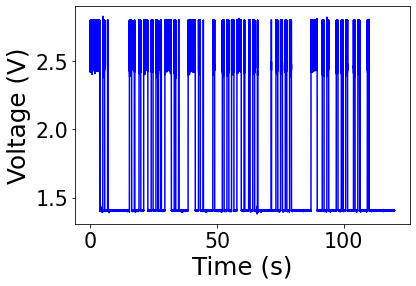

In [339]:
#Trail Entrance 
#Voltage vs Time Charts
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/half_col_scaling
label_font_size = label_font_size_base*high_level_scaling/half_col_scaling
marker_size = marker_size_base*high_level_scaling/half_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/half_col_scaling

i=0
j = 0 
r = "high"
indexes = [1,3,5]
letters = ['a','b','c']
for idx,i in enumerate(indexes):
    print(names_b[i])
    #plt.title(f"Voltage vs Time {names_b[i]} Policy")
    plt.xlabel("Time (s)",fontsize = label_font_size)
    plt.ylabel("Voltage (V)",fontsize = label_font_size)
    plt.tick_params(axis = 'both', labelsize = tick_font_size)
    plt.plot(np.linspace(0,60*2,len((data_frames_split[i][r][" value ch2"]))),(data_frames_split[i][r][" value ch2"]),color="blue")
    plt.savefig(f"./figs/VoltageTraces{letters[idx]}_{names_b[i]}.pdf",format='pdf', dpi=1000, bbox_inches="tight")
    #plt.cla()
    plt.show()
    #plt.plot((data_frames_split[j][r]["power_total"][0:1000]))

## Fig 11

In [340]:
#plot settings
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/half_col_scaling
label_font_size = label_font_size_base*high_level_scaling/half_col_scaling
marker_size = marker_size_base*high_level_scaling/half_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/half_col_scaling

#create data
last = len(average_power_split['high'])-1
indexes_trail = [0,1,3,5,last]
indexes_cafe = [0,2,4,6,last]

x = np.arange(len(indexes_trail)+1)
y1 = np.array([average_power[i] for i in indexes_trail])*1000
y2 = np.array([average_power[i] for i in indexes_cafe])*1000
width = 0.25

l = len(y1)
y1 = y1.tolist()
y2 = y2.tolist()
y1.insert(l-1,.03197184*1000)
y2.insert(l-1,.03197184*1000)
#y1 = y1[0:l-2] + [0.03197184] +y1[l-1]
#y2 = y2[0:l-2] + [0.03197184]+ y2[l-1]
    
e1=[std_power[i] for i in indexes_trail]
e2=[std_power[i] for i in indexes_cafe] 
e1.insert(l-1,11.64648614)
e2.insert(l-1,11.64648614)
# plot data in grouped manner of bar type
plt.bar(x-width/2, y1, width,yerr=e1,hatch='//',fill=True,color="blue")
plt.bar(x+width/2, y2, width,yerr=e2,hatch='--',fill=True, color="red")


plt.xticks(x, legend_methods,fontsize=label_font_size,rotation=50)
plt.xlabel("Baseline",fontsize=label_font_size)
plt.ylabel("Avg. Power (mW)",fontsize=label_font_size)
plt.legend(["Entrance", "Cafe"],fontsize=legend_size,loc='upper center')
plt.axis('tight')
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig(f"./figs/AveragePower_Combo.pdf",format='pdf', dpi=1000, bbox_inches="tight")
plt.show()

In [341]:
y2

[118.272012,
 61.657591715060235,
 60.75562619440337,
 45.3737427181657,
 31.97184,
 92.09181997447115]

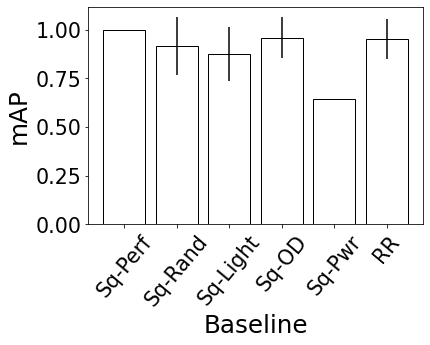

In [342]:
low_avg = (0.06+0.96+.91)/3
cafe_data_f = {"2.8":(1,0),
             "random":(0.9172058062010485,0.14742101216614742),
              "light":(0.8760960823630117,0.13849649413799872),
              "change":(0.9589767251102225,0.10585652485089583),
               "low":(low_avg,0),
              "480p":(0.9516207043984821,0.10205751059181614)}

trail_data_f = {"baseline":(1,0),
             "random":(0.907248694844305,0.21682268493274745),
             "light":(0.7889213016984312,0.333345162223047),
            "change":(0.8927751937984496,0.24752208390426758),
                "low":(low_avg,0),
             "480p":(0.894733275840828,0.2297413082694629)}


# low (0.9080459770114943,0.20335409210292107) +  (0.9137931034482759,0.23002869076079888) + .7

plt.xlabel("Baseline",fontsize=label_font_size)
plt.ylabel("mAP",fontsize=label_font_size)
x = list(range(0,len(cafe_data_f.keys())))
plt.bar(x,list(map(lambda x:x[0],cafe_data_f.values())),yerr=list(map(lambda x:x[1],cafe_data_f.values())),fill=False )
plt.xticks(x,legend_methods ,fontsize=label_font_size,rotation=50)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig(f"./figs/TrailmAP.pdf",format='pdf', dpi=1000, bbox_inches="tight")

In [343]:
low_avg

0.6433333333333334

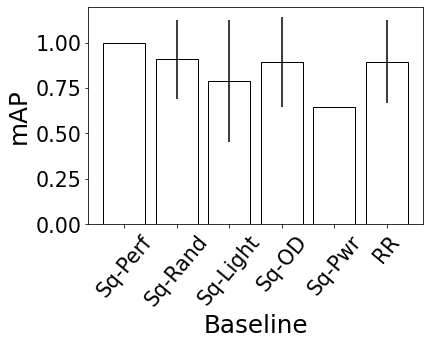

In [344]:
plt.xlabel("Baseline",fontsize=label_font_size)
plt.ylabel("mAP",fontsize=label_font_size)
x = list(range(0,len(cafe_data_f.keys())))
plt.bar(x,list(map(lambda x:x[0],trail_data_f.values())),yerr=list(map(lambda x:x[1],trail_data_f.values())),fill=False )
plt.xticks(x, legend_methods,fontsize=label_font_size,rotation=50)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig(f"./figs/CafemAP.pdf",format='pdf', dpi=1000, bbox_inches="tight")

In [345]:
#plot settings
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/half_col_scaling
label_font_size = label_font_size_base*high_level_scaling/half_col_scaling
marker_size = marker_size_base*high_level_scaling/half_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/half_col_scaling

#create data
last = len(average_power_split['high'])-1
indexes = [0,2,4,6,8,last]

x = np.arange(len(indexes))
y1 = list(map(lambda x:x[0],cafe_data_f.values()))
y2 = list(map(lambda x:x[0],trail_data_f.values()))
width = 0.25


# plot data in grouped manner of bar type
e1= list(map(lambda x:x[1],trail_data_f.values()))
e1 = [e1,np.array(e1) - ((np.array(e1)+np.array(y2)) - 1)]
e1[0][4] = 0
e1[1][4] = 0 

e2= list(map(lambda x:x[1],trail_data_f.values()))
e2 = [e2,np.array(e2) - ((np.array(e2)+np.array(y1)) - 1)]
e2[0][4] = 0
e2[1][4] = 0 

plt.bar(np.array(list(range(0,len(cafe_data_f.keys()))))+width/2, y2, width,yerr=e1,hatch='--',fill=True, color="blue")
plt.bar(np.array(list(range(0,len(cafe_data_f.keys()))))-width/2, y1, width,yerr=e2,hatch='//',fill=True,color="red")

#plt.bar(x+width, y3, width,yerr=[average_power_split['low-std'][i] for i in indexes],hatch='..',fill=False)


plt.xticks(x, legend_methods,fontsize=label_font_size,rotation=50)
plt.xlabel("Baseline",fontsize=label_font_size)
plt.ylabel("mAP",fontsize=label_font_size)
plt.legend(["Entrance", "Cafe"],fontsize=legend_size,loc='upper left')
plt.axis('tight')
plt.ylim(0,1.5)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig(f"./figs/map_combo.pdf",format='pdf', dpi=1000, bbox_inches="tight")
plt.show()

In [346]:
x

array([0, 1, 2, 3, 4, 5])

In [347]:
y1 = list(map(lambda x:x[0],cafe_data_f.values()))
y1

[1,
 0.9172058062010485,
 0.8760960823630117,
 0.9589767251102225,
 0.6433333333333334,
 0.9516207043984821]

# Figure 12

### Simulation

In [348]:
data_close_r = {'2.8': (0.08261930092869332, 0.0015528753078621),
 '2.0': (0.0695689909712865, 0.0005179286725771192),
 '1.8': (0.07266679243080937, 0.0006425159381182825),
 '1.4': (0.23785900809175697, 0.25597532764703707),
 'RR' :  (0.8639920755843253, 1.0027330353245312)}

data_close_t = {'2.8': (0.005083347899818022, 6.718520727600731e-07),
 '2.0': (0.005069542914280222, 5.173212809572066e-07),
 '1.8': (0.005143351745347177, 7.017299451493388e-07),
 '1.4': (0.016574853326425856, 0.0012063953411780494),
 'RR' : (0.1014849022828926, 0.019209536805246768)}

data_far_r = {'2.8': (1.0500292455288864, 1.016043567960141),
 '2.0': (1.2760954479244546, 1.6101380754679737),
 '1.8': (0.994294563303928, 0.9579993972018489),
 '1.4': (0.4054499307184435, 0.47018999015668134),
  'RR':  (1.5537341924410757, 1.4451069778329855)}

data_far_t = {'2.8': (0.1014849022828926, 0.019209536805246768),
 '2.0': (0.13143820726294475, 0.02113855413856242),
 '1.8': (0.10144285847348644, 0.01939287583138232),
 '1.4': (0.037941987677959324, 0.009169461716809747),
  "RR":  (0.1014849022828926, 0.019209536805246768)}

power_data = {'1.4': (31.97184409775719, 135.64063937538137),
 '1.5': (39.58383927898389, 206.81922805998676),
 '1.6': (47.77292435674655, 298.59228130399356),
 '1.7': (56.662782970762116, 425.05849935615356),
 '1.8': (65.5244847792147, 596.5578840999893),
 '1.9': (74.28166248908028, 814.7435750715532),
 '2.0': (82.5114279167174, 1039.4594804893763),
 '2.1': (90.33755836186393, 1289.287042438553),
 '2.2': (97.79145494327533, 1602.8796496596021),
 '2.3': (105.19745435085278, 1964.7188315160745),
 '2.4': (112.02695488414749, 2314.446328293533),
 '2.5': (115.48772794718724, 2402.9426288808013),
 '2.6': (116.50807224397641, 2283.4425610248936),
 '2.7': (117.1475853240965, 2170.4941479812974),
 '2.8': (118.27306627435667, 2065.979541162451),
  'RR': (92.09181997447115,85.90667830669737)}

In [349]:
#simulation 
#6 minutes 
#half close 
frame_n = 60*6*24
voltages = ["2.8","2.0","1.8","1.4"]


In [350]:
power_avg = 0
power_var = 0
t_avg = 0
t_var = 0 

power = []
t = [] 
r = []

results = {"nominal":{"p":0,"t":0, "r":0},
          "random":{"p":0,"t":0, "r":0},
          "distance":{"p":0,"t":0, "r":0},
           "low":{"p":0,"t":0, "r":0},
          "RR":{"p":0,"t":0, "r":0}}

#random policy
for n in range(0,frame_n): 
    volt = random.choice(voltages)
    power.append(np.random.normal(loc=power_data[volt][0], scale=np.sqrt(power_data[volt][1]), size=1)) 
    #print(power[-1])
    if(random.random() < 0.5): 
        #close 
        t.append(np.random.normal(loc=data_close_t[volt][0], scale=np.sqrt(data_close_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=np.sqrt(data_close_r[volt][1]), size=1))
    else: 
        t.append(np.random.normal(loc=data_far_t[volt][0], scale=np.sqrt(data_far_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=np.sqrt(data_close_r[volt][1]), size=1))

power = np.array(power)
t = np.array(t)
r = np.array(r)
    

In [351]:
results["random"]["p"] = (power.mean(),power.std())
results["random"]["r"] = (r.mean(),r.std())
results["random"]["t"] = (t.mean(),t.std())

In [352]:
#low policy
power = []
t = [] 
r = []

for n in range(0,frame_n): 
   # volt = random.choice(voltages)
    volt = "1.4"
    #print(power[-1])
    if(random.random() < 0.5): 
        #close 
        t.append(np.random.normal(loc=data_close_t[volt][0], scale=np.sqrt(data_close_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=np.sqrt(data_close_r[volt][1]), size=1))
    else: 
        t.append(np.random.normal(loc=data_far_t[volt][0], scale=np.sqrt(data_far_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=np.sqrt(data_close_r[volt][1]), size=1))
    power.append(np.random.normal(loc=power_data[volt][0], scale=np.sqrt(power_data[volt][1]), size=1))
    
    
power = np.array(power)
t = np.array(t)
r = np.array(r)
results["low"]["p"] = (power.mean(),power.std())
results["low"]["t"] = (t.mean(),t.std())
results["low"]["r"] = (r.mean(),t.std())

In [353]:
power = []
t = [] 
r = []

#if close low else high
for n in range(0,frame_n): 
   # volt = random.choice(voltages)
     
    #print(power[-1])
    if(random.random() < 0.5): 
        #close 
        t.append(np.random.normal(loc=data_close_t[volt][0], scale=np.sqrt(data_close_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=np.sqrt(data_close_r[volt][1]), size=1))
        volt = "1.4"
    else: 
        t.append(np.random.normal(loc=data_far_t[volt][0], scale=np.sqrt(data_far_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=np.sqrt(data_close_r[volt][1]), size=1))
        volt = "2.8"
    power.append(np.random.normal(loc=power_data[volt][0], scale=np.sqrt(power_data[volt][1]), size=1))
    
    
power = np.array(power)
t = np.array(t)
r = np.array(r)

results["distance"]["p"] = (power.mean(),power.std())
results["distance"]["t"] = (t.mean(),t.std())
results["distance"]["r"] = (r.mean(),t.std())

In [354]:
#Nominal
power = []
t = [] 
r = []

for n in range(0,frame_n): 
   # volt = random.choice(voltages)
    volt = "2.8"
    #print(power[-1])
    if(random.random() < 0.5): 
        #close 
        t.append(np.random.normal(loc=data_close_t[volt][0], scale=np.sqrt(data_close_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=np.sqrt(data_close_r[volt][1]), size=1))
    else: 
        t.append(np.random.normal(loc=data_far_t[volt][0], scale=np.sqrt(data_far_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=np.sqrt(data_close_r[volt][1]), size=1))
    power.append(np.random.normal(loc=power_data[volt][0], scale=np.sqrt(power_data[volt][1]), size=1))
    
    
power = np.array(power)
t = np.array(t)
r = np.array(r)
results["nominal"]["p"] = (power.mean(),power.std())
results["nominal"]["t"] = (t.mean(),t.std())
results["nominal"]["r"] = (r.mean(),t.std())

In [355]:
#RR
power = []
t = [] 
r = []

for n in range(0,frame_n): 
   # volt = random.choice(voltages)
    volt = "RR"
    #print(power[-1])
    if(random.random() < 0.5): 
        #close 
        t.append(np.random.normal(loc=data_close_t[volt][0], scale=np.sqrt(data_close_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=np.sqrt(data_close_r[volt][1]), size=1))
    else: 
        t.append(np.random.normal(loc=data_far_t[volt][0], scale=np.sqrt(data_far_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=np.sqrt(data_close_r[volt][1]), size=1))
    power.append(np.random.normal(loc=power_data[volt][0], scale=np.sqrt(power_data[volt][1]), size=1))
    
    
power = np.array(power)
t = np.array(t)
r = np.array(r)
results["RR"]["p"] = (power.mean(),power.std())
results["RR"]["t"] = (t.mean(),t.std())
results["RR"]["r"] = (r.mean(),t.std())

In [356]:
results

{'nominal': {'p': (118.154052126182, 44.6112005951971),
  't': (0.05430999525138537, 0.10980862289912295),
  'r': (0.08271060982148593, 0.10980862289912295)},
 'random': {'p': (74.78817502490882, 43.81132522977474),
  't': (0.05041767563648966, 0.10443113428432779),
  'r': (0.12149785986555328, 0.2588466374681608)},
 'distance': {'p': (74.91234865925988, 54.441748320597426),
  't': (0.03898453682509689, 0.09305844180158065),
  'r': (0.16292529735833813, 0.09305844180158065)},
 'low': {'p': (32.227369201093204, 11.730834736404908),
  't': (0.027859332004143415, 0.07431750474603237),
  'r': (0.23876046539915644, 0.07431750474603237)},
 'RR': {'p': (91.93264436363802, 9.239172674728366),
  't': (0.09984328339854796, 0.13990111401522404),
  'r': (0.8709233050575121, 0.13990111401522404)}}

In [357]:
#translational norm 
legend_marker = ["Sq-Perf","Sq-Rand","Sq-Dist","Sq-Pwr","RR"]
plt.xlabel("Baseline",fontsize=label_font_size)
plt.ylabel("Error (m)",fontsize=label_font_size)
x = list(range(0,len(results.keys())))
plt.bar(x,[results[k]["t"][0] for k in results.keys() ],yerr=[results[k]["t"][1] for k in results.keys()],fill=True,color="blue" )
plt.xticks(x, legend_marker,fontsize=label_font_size,rotation=50)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.ylim(0,.25)
plt.savefig(f"./figs/translational_norm.pdf",format='pdf', dpi=1000, bbox_inches="tight")

In [358]:
#rotational norm 
plt.xlabel("Baseline",fontsize=label_font_size)
plt.ylabel("L2 Norm",fontsize=label_font_size)
x = list(range(0,len(results.keys())))
plt.bar(x,[results[k]["r"][0] for k in results.keys() ],yerr=[results[k]["r"][1] for k in results.keys()],fill=True,color="blue" )
plt.xticks(x, legend_marker, fontsize=label_font_size,rotation=50)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.ylim(0,1)
plt.savefig(f"./figs/rotational_norm.pdf",format='pdf', dpi=1000, bbox_inches="tight")

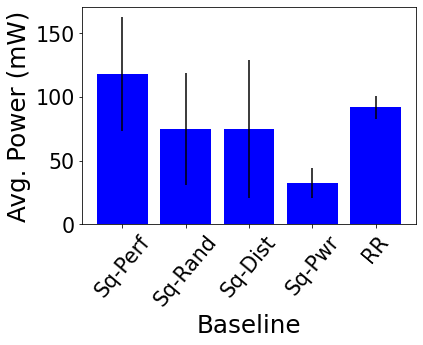

In [359]:
#rotational norm 
plt.xlabel("Baseline",fontsize=label_font_size)
plt.ylabel("Avg. Power (mW)",fontsize=label_font_size)
x = list(range(0,len(results.keys())))
plt.bar(x,[results[k]["p"][0] for k in results.keys() ],yerr=[results[k]["p"][1] for k in results.keys()],fill=True,color="blue" )
plt.xticks(x, legend_marker,fontsize=label_font_size,rotation=50)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
#plt.ylim(0,1)
plt.savefig(f"./figs/pose_power.pdf",format='pdf', dpi=1000, bbox_inches="tight")

## Fig 13

In [360]:
S_U = 10
S_R = 10/5
V_REF = 3.3
BIT_ADC = 10
f = 1338.53
T = 1/f 
voltages = [2.8,2.7,2.6,2.5,2.4,2.3,2.2,2.1,2.0,1.9,1.8,1.7,1.6,1.5,1.4]
resolutions = ["mode-1","mode-2","mode-3","mode-4","mode-5","mode-6","mode-7"]
voltages.reverse()
data_frames = [] 
data_frames_res = [] 

def calc_derived_value(data_frame):
    delta_voltage_analog = np.abs(data_frame[" value ch1"] - data_frame[" value ch0"])
    current_analog = delta_voltage_analog / S_U
    power_analog = current_analog * data_frame[" value ch2"]
    
    delta_digital_voltage = np.abs(data_frame[" value ch4"] - data_frame[" value ch3"])
    current_digital = delta_digital_voltage / S_R
    power_digital = current_digital * data_frame[" value ch2"] 
    
    delta_control_voltage = np.abs(data_frame[" value ch5"] - data_frame[" value ch6"])
    power_control = (delta_control_voltage/ S_R) * V_REF
    
    data_frame["power_analog"] = power_analog
    data_frame["power_digital"] = power_digital
    data_frame["power_total"] = power_analog + power_digital
    data_frame["power_control"] = power_control 
    
    return(data_frame)

for volt in voltages: 
    df = pd.read_csv( f"./data/{volt}.csv",skiprows=1)
    keys_values = list(filter(lambda x : "value" in x, df.keys()))
    keys_samples = list(filter(lambda x : "sample" in x, df.keys()))
    df[keys_values] = (df[keys_values] / (2**BIT_ADC))*V_REF
    df = calc_derived_value(df)
    data_frames.append(df)


#resolutions 
for res in resolutions: 
    df = pd.read_csv( f"./data/{res}.csv",skiprows=1)
    keys_values = list(filter(lambda x : "value" in x, df.keys()))
    keys_samples = list(filter(lambda x : "sample" in x, df.keys()))
    df[keys_values] = (df[keys_values] / (2**BIT_ADC))*V_REF
    df = calc_derived_value(df)
    data_frames_res.append(df)
    
    


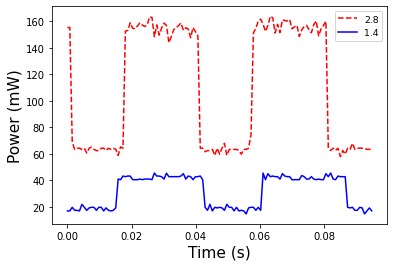

In [361]:
#plot settings
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/full_col_scaling
label_font_size = label_font_size_base*high_level_scaling/full_col_scaling
marker_size = marker_size_base*high_level_scaling/full_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/full_col_scaling
num_s = 127
off_set = 17
plt.xlabel("Time (s)",fontsize=label_font_size)
plt.ylabel("Power (mW)",fontsize=label_font_size)
plt.plot(np.linspace(0,num_s,num_s)*T,data_frames[-1]["power_total"][0:num_s]*1000,color="red",linestyle="--",label="2.8")
plt.plot(np.linspace(0,num_s,num_s)*T, data_frames[0]["power_total"][off_set:num_s+off_set]*1000,color="blue",label ="1.4")
plt.legend(fontsize=legend_size)
plt.savefig(f"./figs/power_traces.pdf",format='pdf', dpi=1000, bbox_inches="tight")